In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from scipy import signal
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

corpus = tu.Corpus('TIMIT')
train = corpus.train
test = corpus.test
corpus.train, corpus.test

(<timit_utils.core.SubCorpus at 0x272549747b8>,
 <timit_utils.core.SubCorpus at 0x27255420b00>)

### Check for length of sentences.

Max sentence length in training set is  7.7888125  seconds.
Min sentence length in training set is  0.91525  seconds.


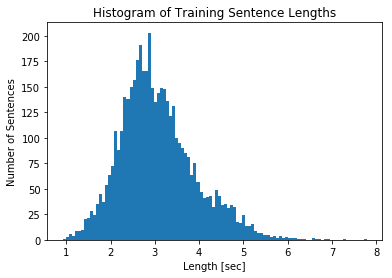

In [4]:
sentence_lengths = []
for p in range(len(train.people)):
    for s in range(len(train.person_by_index(p).sentences)):
        sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
        sentence_lengths.append(len(sentence))
print('Max sentence length in training set is ', max(sentence_lengths)/16000, ' seconds.')
print('Min sentence length in training set is ', min(sentence_lengths)/16000, ' seconds.')
plt.hist([x / 16000 for x in sentence_lengths], bins=100)
plt.title('Histogram of Training Sentence Lengths')
plt.xlabel('Length [sec]')
plt.ylabel('Number of Sentences')
plt.show()

Max sentence length in testing set is  7.57125  seconds.
Min sentence length in testing set is  1.0944375  seconds.


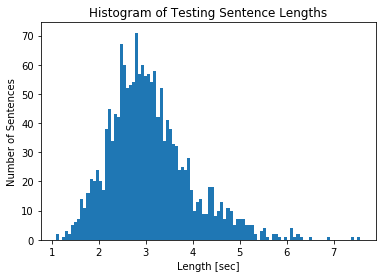

In [5]:
sentence_lengths = []
for p in range(len(test.people)):
    for s in range(len(test.person_by_index(p).sentences)):
        sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
        sentence_lengths.append(len(sentence))
print('Max sentence length in testing set is ', max(sentence_lengths)/16000, ' seconds.')
print('Min sentence length in testing set is ', min(sentence_lengths)/16000, ' seconds.')
plt.hist([x / 16000 for x in sentence_lengths], bins=100)
plt.title('Histogram of Testing Sentence Lengths')
plt.xlabel('Length [sec]')
plt.ylabel('Number of Sentences')
plt.show()

### Make all training and testing samples the same length in time.

In [6]:
L = 1 #seconds

training_set = []
training_label = []
for p in range(len(train.people)):
    for s in range(len(train.person_by_index(p).sentences)):
        sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
        sentence_lengths.append(len(sentence))
        start = 0
        end = len(sentence)
        while end >= round(16000*L):
            training_set.append(sentence[start:start+round(16000*L)])
            training_label.append(train.person_by_index(p).name)
            start = start+round(16000*L)
            end = end-round(16000*L)

testing_set = []
testing_label = []
for p in range(len(test.people)):
    for s in range(len(test.person_by_index(p).sentences)):
        sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
        sentence_lengths.append(len(sentence))
        start = 0
        end = len(sentence)
        while end >= round(16000*L):
            testing_set.append(sentence[start:start+round(16000*L)])
            testing_label.append(test.person_by_index(p).name)
            start = start+round(16000*L)
            end = end-round(16000*L)

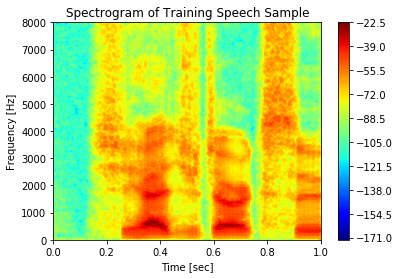

In [41]:
plt.title('Spectrogram of Training Speech Sample')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')
f, t, spectrogram = scipy.signal.stft(training_set[0], nperseg=round(0.02*16000), fs=16000, detrend=False, window=np.hamming(round(0.02*16000)), noverlap=round(0.7*0.02*16000))
plt.contourf(t,f,20*np.log10(abs(spectrogram)),100,cmap='jet')
plt.colorbar()
plt.show()

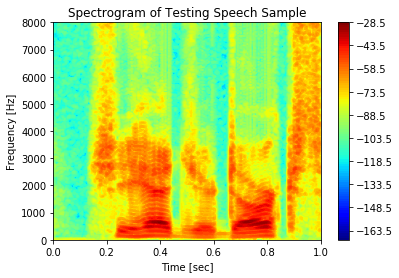

In [42]:
plt.title('Spectrogram of Testing Speech Sample')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')
f, t, spectrogram = scipy.signal.stft(testing_set[0], nperseg=round(0.02*16000), fs=16000, detrend=False, window=np.hamming(round(0.02*16000)), noverlap=round(0.7*0.02*16000))
plt.contourf(t,f,20*np.log10(abs(spectrogram)),100,cmap='jet')
plt.colorbar()
plt.show()

### How many speakers are in test and train sets?

In [43]:
num_tr_speakers = len(set(training_label))
num_te_speakers = len(set(testing_label))
print('Number of speakers in training data: ', num_tr_speakers)
print('Number of speakers in testing data: ', num_te_speakers)

Number of speakers in training data:  462
Number of speakers in testing data:  168


Not all speakers are in both sets... So I need to mix it up so that all speakers are in the training set so that the model is able to ID all speakers.

In [44]:
data = testing_set+training_set
labels = testing_label+training_label
test_set = []
train_set = []
test_label = []
train_label = []
done = 0
count = 0
while done==0:
    if count%4==0:
        test_set.append(data[count])
        test_label.append(labels[count])
    else:
        train_set.append(data[count])
        train_label.append(labels[count])
    count = count+1
    if count==len(labels):
        done = 1

num_tr_speakers = len(set(train_label))
num_te_speakers = len(set(test_label))
print('Number of speakers in training data: ', num_tr_speakers)
print('Number of speakers in testing data: ', num_te_speakers)

Number of speakers in training data:  630
Number of speakers in testing data:  630


### Data loaders for time-series input.

In [46]:
batch_size = 100
train_loader,test_loader = {},{}
im_size = spectrogram.shape
num_speakers = len(set(train_label))
train_list = []
for ind, data in enumerate(train_set):
    train_list.append((data, train_label[ind]))
test_list = []
for ind, data in enumerate(test_set):
    test_list.append((data, test_label[ind]))
train_loader['timit'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['timit'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=True, num_workers=0)

### Data saved as spectrogram images

In [47]:
batch_size = 100
train_loader,test_loader = {},{}
im_size = spectrogram.shape
num_speakers = len(set(train_label))
train_list = []
for ind, data in enumerate(train_set):
    f, t, spectrogram = scipy.signal.stft(train_set[ind], nperseg=round(0.02*16000), fs=16000, detrend=False, window=np.hamming(round(0.02*16000)), noverlap=round(0.7*0.02*16000))
    train_list.append((20*np.log10(abs(spectrogram)), train_label[ind]))
test_list = []
for ind, data in enumerate(test_set):
    f, t, spectrogram = scipy.signal.stft(test_set[ind], nperseg=round(0.02*16000), fs=16000, detrend=False, window=np.hamming(round(0.02*16000)), noverlap=round(0.7*0.02*16000))
    test_list.append((20*np.log10(abs(spectrogram)), train_label[ind]))
train_loader['timit'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['timit'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=True, num_workers=0)
print('done')

done


### Construct the CNN architecture.

In [77]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=4, stride=2, padding=0, bias=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0, bias=True)
        self.fc1   = nn.Linear(in_features=64, out_features=120) if data_name == 'mnist' else nn.Linear(in_features=16*6*6, out_features=120)
        self.fc2   = nn.Linear(in_features=120, out_features=84)
        self.fc3   = nn.Linear(in_features=84, out_features=out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 4)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 4)
        x = x.view(x.size(0), -1) # flattens
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [78]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.reshape(len(data),1,data[0].size()[0],data[0].size()[1])
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) #sometimes different criteria requires multiplying by batch size
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, test_loss, 100. * correct / len(test_loader.dataset)))

In [79]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

In [80]:
seed = 1
device = 'cpu'
data_name = 'timit'
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'
num_epochs = 10
lr = 0.05
device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
in_channels = 1
out_channels = 630
model = LeNet5(in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test(model, device, test_loader[data_name], criterion, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))
    

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'weight'